<h1 align="center">Домашняя работа 2<h1 align="center">

Домашнее задание 2.

Введение в анализ данных (первый семестр)

Дедлайн сдачи домашнего задания: 2 апреля, 22:00. После дедлайна решения не принимаются.

В курсе “Алгоритмы интеллектуальной обработки больших объемов данных” вам необходимо реализовать алгоритм K-Means. В этом домашнем задании вам нужно будет ускорить работу программы.

Работа должна состоять из двух частей:
1. Напишите максимально быструю реализацию на python (без использования cython, numba и кода на других языках программирования). Скорее всего вам поможет векторизация вашего кода (переход от циклов к матричным вычислениям в numpy).
2. Реализуйте k-means на cython.

Помимо написания кода, нужно сделать следующее.
1. Объяснить, почему вы считаете, что быстрее сделать нельзя. Отдельно для кода на python и для кода cython. В последнем случае вам может помочь флаг -a.
2. Сравнить скорость работы различных реализаций алгоритмов.

Для тестирования используйте датасет, на котором вы проверяли работу алгоритма K-means в домашнем задании курса “Алгоритмы интеллектуальной обработки больших объемов данных”.

Домашнее задание необходимо сделать в одном jupyter notebook.

P.S. Понимаю, что в интернете существует множество уже готовых реализаций, но постарайтесь разобраться и сделать все самостоятельно. Копи-паст кода повлияет в худшую сторону на общую оценку за курс.

<h2 align="center">Приступим к выполнению. </h2>
<h3>Замечание! В своей работе я медленными шагами шёл от плохо написанного кода до более-менее удачной реализации как на Python, так и на Cython. При проверке Вы можете скипнуть пункты с beta-алгоритмами и посмотреть только final-версии.</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from line_profiler import LineProfiler

%matplotlib inline
%load_ext Cython

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

In [2]:
def profile_print(func_to_call, *args):
    profiler = LineProfiler()
    profiler.add_function(func_to_call)
    profiler.runcall(func_to_call, *args)
    profiler.print_stats()

In [3]:
from sklearn.datasets import make_blobs

In [4]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

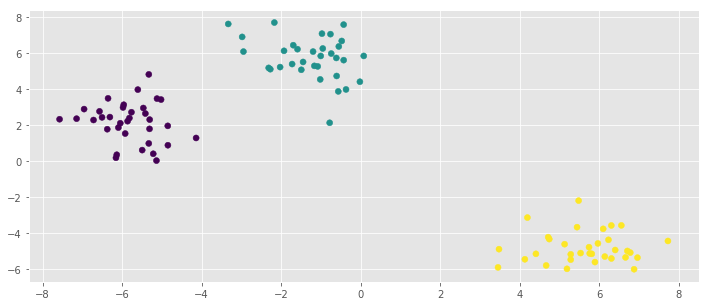

In [5]:
plt.scatter(X[:,0], X[:, 1], c=y)

<center>Pic.1 Default x and y</center>

<h3 align="center">Загрузим и нормализуем реальные данные</h3>

In [6]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns_only=df_sns.ix[:,4:40]
df_sns_only_norm = (df_sns_only - df_sns_only.mean()) / df_sns_only.
real_data=df_sns_only_norm.as_matrix()

<h3 align="center">Попробуем написать Kmeans в лоб</h3>

In [7]:
from sklearn.base import ClusterMixin,BaseEstimator
class Kmeans_beta1(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, min_error_rate=None):
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.min_error_rate=min_error_rate

    def fit(self, X, y=None):
        np.random.seed(self.random_state)
        self.labels = np.empty(X.shape[0])
        c_indexes = np.random.choice(len(X), size=self.k)
        temp_centroids = np.empty((self.k, X.shape[1]))#compare array
        self.centroids = [X[i]for i in c_indexes]
        average=dict()
        for p in xrange (0,self.max_iter):
            for point in X:
                itemindex=0#need for labels
                min_value=np.inf
                for i in xrange (0,self.k):
                    temp_value=0
                    for j in xrange(0,len(X.shape)):
                        temp_value+=(self.centroids[i][j]-point[j])**2
                    if (temp_value<min_value):
                        min_value=temp_value
                        itemindex = np.where(X==point)
                        self.labels[itemindex[0][0]]=i
            for label in set(self.labels):
                list_coordinates=[]
                for j in xrange(0,len(X.shape)):
                    list_coordinates.append(np.average(X[:,j][self.labels==label]))
                average[label]=list_coordinates
            for i in xrange(0,self.k):
                temp_centroids[i]=np.array(average[i])
            if abs(abs(np.average(temp_centroids))-abs(np.average(self.centroids)))<self.min_error_rate:
                break
            else: self.centroids=temp_centroids
        return self

    def predict(self, X, y=None):
        labels_predict=np.empty(X.shape[0])#predict labels for centroids after fit
        for point in X:
            itemindex=0#need for labels
            min_value=np.inf
            for i in xrange (0,self.k):
                temp_value=0
                for j in xrange(0,len(X.shape)):
                    temp_value+=(self.centroids[i][j]-point[j])**2
                if (temp_value<min_value):
                    min_value=temp_value
                    itemindex = np.where(X==point)
                    labels_predict[itemindex[0][0]]=i
        return labels_predict

<h3 align="center">Проверим Kmeans_beta1 на искусственных данных</h3>

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


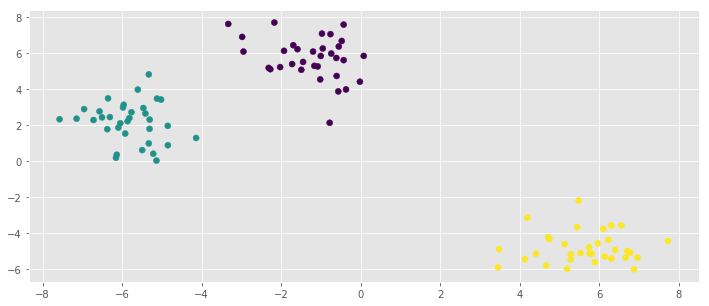

In [8]:
%time
model = Kmeans_beta1(k=3, min_error_rate=0.1, random_state=10)
model.fit(X, y)
claster_labels=model.predict(X,y)
plt.scatter(X[:,0], X[:, 1],c=claster_labels)

In [9]:
profile_print(model.fit,X, y)

Timer unit: 1e-06 s

Total time: 0.01629 s
File: <ipython-input-7-b57c4a75ddae>
Function: fit at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                               def fit(self, X, y=None):
    12         1           49     49.0      0.3          np.random.seed(self.random_state)
    13         1           17     17.0      0.1          self.labels = np.empty(X.shape[0])
    14         1          127    127.0      0.8          c_indexes = np.random.choice(len(X), size=self.k)
    15         1            5      5.0      0.0          temp_centroids = np.empty((self.k, X.shape[1]))#compare array
    16         4           17      4.2      0.1          self.centroids = [X[i]for i in c_indexes]
    17         1            2      2.0      0.0          average=dict()
    18         2            5      2.5      0.0          for p in xrange (0,self.max_iter):
    19       202          322      1.6      2.0              for point in X:
   

<center>Pic.2 Kmeans_beta1 на искусственных данных

<h3 align="center">Вывод: такая реализация будет очень долго обрабатывать 5000 точек из реального дата-сета</h3>

<h3 align="center">Попробуем ускорить алгоритм</h3>

In [10]:
from sklearn.base import ClusterMixin,BaseEstimator
class Kmeans_beta2(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, min_error_rate=None):
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.min_error_rate=min_error_rate

    def fit(self, X, y=None):
        np.random.seed(self.random_state)
        self.labels = np.empty(X.shape[0])
        self.centroids = np.empty((self.k, X.shape[1]))
        
        #нужно для: X_pd.index, X_pd.columns, X_pd.loc[i], np.asarray(X_pd)
        X_pd=pd.DataFrame(X)
        #булев массив
        bol_true=np.empty(len(X_pd.columns))
        for i in range(len(X_pd.columns)):
            bol_true[i] = True
        #иниц. центройдов точками
        c_indexes = np.random.choice(len(X_pd.index), size=self.k)
        self.centroids = [X_pd.loc[i] for i in c_indexes]
        #нужен для сравнения
        centroids_temp = np.empty((self.k, X.shape[1]))
        
        for i in range(0,self.max_iter):
            #ближайший центройд для точки
            self.labels = np.argmin(np.array(
                [np.linalg.norm(np.asarray(X_pd)-np.asarray(c), ord=2, axis=-1) for c in self.centroids]), axis=0)
            lbls=set()
            for item in self.labels:
                lbls.add(item)
            #пересчитываем новый центройд 
            centroids_temp=[np.average(X[self.labels==i],axis=0)for i in lbls]
            #для операции минус
            centroids_temp_array=np.asarray(centroids_temp)
            centroids_array=np.asarray(self.centroids)
            #критерий остановки
            if (abs(centroids_temp_array-centroids_array)< self.min_error_rate).all() == bol_true.all():
                break
            else: self.centroids=centroids_temp
        return self

    def predict(self, X, y=None):
        X_pd=pd.DataFrame(X)
        labels_predict = np.argmin(np.array(
                [np.linalg.norm(np.asarray(X_pd)-np.asarray(c), ord=2, axis=-1) for c in self.centroids]), axis=0)
        return labels_predict

In [11]:
#Зададим точность метода - это вектор размерности k
X_pd=pd.DataFrame(X)
min_error_rate = np.empty(len(X_pd.columns))
for i in range(len(X_pd.columns)):
    min_error_rate[i] = 0.01

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


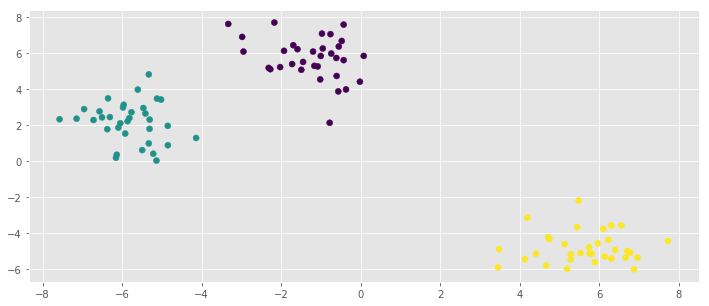

In [12]:
%time
model = Kmeans_beta2(3, 'euclidean', 1000, 10, min_error_rate)
model.fit(X, y)
claster_labels=model.predict(X,y)
plt.scatter(X[:,0], X[:, 1],c=claster_labels)

<center>Pic.3 Kmeans_beta2 - make_blobs </center>

<h3 align="center">Посмотрим работу Kmeans_beta2 на реальных данных</h3>

In [13]:
#Зададим точность метода
X_pd=pd.DataFrame(real_data)
min_error_rate = np.empty(len(X_pd.columns))
for i in range(len(X_pd.columns)):
    min_error_rate[i] = 0.01

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


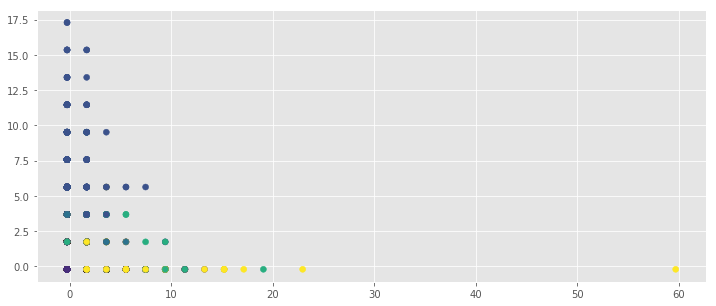

In [14]:
%time
model = Kmeans_beta2(k=9, min_error_rate=min_error_rate, random_state=10)
model.fit(real_data, y)
claster_labels=model.predict(real_data,y)
plt.scatter(real_data[:,5], real_data[:, 6],c=claster_labels)

<center>Pic.4 Kmeans_beta2 - real data</center>

In [15]:
profile_print(model.fit, real_data, y)

Timer unit: 1e-06 s

Total time: 6.0814 s
File: <ipython-input-10-2c951d89514b>
Function: fit at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                               def fit(self, X, y=None):
    12         1           15     15.0      0.0          np.random.seed(self.random_state)
    13         1           22     22.0      0.0          self.labels = np.empty(X.shape[0])
    14         1           12     12.0      0.0          self.centroids = np.empty((self.k, X.shape[1]))
    15                                                   
    16                                                   #нужно для: X_pd.index, X_pd.columns, X_pd.loc[i], np.asarray(X_pd)
    17         1          615    615.0      0.0          X_pd=pd.DataFrame(X)
    18                                                   #булев массив
    19         1           24     24.0      0.0          bol_true=np.empty(len(X_pd.columns))
    20        37           57      1.5

<h3 align="center">Попробуем еще ускорить. Я назову это удачной реализацией, написанной на Python.</h3>

In [13]:
from sklearn.base import ClusterMixin,BaseEstimator
class Kmeans_final_python(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, min_error_rate=None):
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.min_error_rate=min_error_rate

    def fit(self, X, y=None):
        prev_step_sum=10000#need for min_error_rate condition
        cur_step_sum=0
        np.random.seed(self.random_state)#random_state
        c_indexes = np.random.choice(len(X), size=self.k)#init centroids
        self.centroids = [X[i] for i in c_indexes]
        counter=0#need for max_iter condition
        while abs(prev_step_sum - cur_step_sum) > self.min_error_rate and counter<self.max_iter:
            self.labels = np.argmin(np.array(
                    [np.linalg.norm(X-c, ord=2, axis=-1) for c in self.centroids]), axis=0)
            prev_step_sum=np.sum(self.centroids)
            self.centroids=np.array([np.average(X[self.labels == k], axis = 0)
                    for k in range(self.k)])
            cur_step_sum=np.sum(self.centroids)
            counter+=1  
        return self
    def predict(self, X, y=None):
        labels_predict = np.argmin(np.array(
                [np.linalg.norm(X-c, ord=2, axis=-1) for c in self.centroids]), axis=0)
        return labels_predict

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


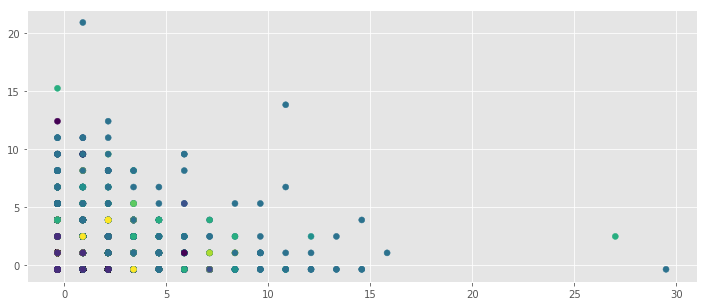

In [14]:
%time
model = Kmeans_final_python(k=9, min_error_rate=0.01, random_state=10, max_iter=10000)
model.fit(real_data, y)
claster_labels=model.predict(real_data,y)
plt.scatter(real_data[:,0], real_data[:,1],c=claster_labels)

<center>Pic.4 Kmeans_beta3 - real data</center>

In [18]:
profile_print(model.fit, real_data, y) 

Timer unit: 1e-06 s

Total time: 2.14331 s
File: <ipython-input-16-f71f9a04b37c>
Function: fit at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                               def fit(self, X, y=None):
    12         1            2      2.0      0.0          prev_step_sum=10000#need for min_error_rate condition
    13         1            1      1.0      0.0          cur_step_sum=0
    14         1           14     14.0      0.0          np.random.seed(self.random_state)#random_state
    15         1          104    104.0      0.0          c_indexes = np.random.choice(len(X), size=self.k)#init centroids
    16        10           26      2.6      0.0          self.centroids = [X[i] for i in c_indexes]
    17         1            1      1.0      0.0          counter=0#need for max_iter condition
    18        24          138      5.8      0.0          while abs(prev_step_sum - cur_step_sum) > self.min_error_rate and counter<self.max_iter:
 

<h3 align="center">Посмотрим сколько работает алгоритм из sklearn'а</h3>

In [19]:
from sklearn.cluster import KMeans

In [20]:
model = KMeans(n_clusters=9, tol=0.01, random_state=10, max_iter=10000)

In [21]:
profile_print(model.fit, real_data, y)

Timer unit: 1e-06 s

Total time: 4.19275 s
File: /Users/RomanDegtyarev/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py
Function: fit at line 871

Line #      Hits         Time  Per Hit   % Time  Line Contents
   871                                               def fit(self, X, y=None):
   872                                                   """Compute k-means clustering.
   873                                           
   874                                                   Parameters
   875                                                   ----------
   876                                                   X : array-like or sparse matrix, shape=(n_samples, n_features)
   877                                                       Training instances to cluster.
   878                                                   """
   879         1           39     39.0      0.0          random_state = check_random_state(self.random_state)
   880         1         1019   1019.0

<h3>Для того, чтобы сказать, что можно остановиться на этой реализации нужно вспомнить алгоритм, который был оглашен на первой лекции.</h3>
### Алгоритм

1. Выбрать заданное количество начальных центроидов случайным образом
2. Для каждой точки из датасета присвоить кластер, соответствующий ближайшему центроиду
$$C_k = {x_n : ||x_n - \mu_k|| \leq all ||x_n - \mu_l||} $$
3. Для каждого кластера выбрать новый центроид, посчитав среднее 
$$\mu_k = \frac{1}{C_k} \sum _{x_n \in C_k} x_n$$
4. Повторять 2 и 3 до тех пор, пока изменения перестанут быть существенными 

Пройдемся по пунктам:
- <b>Пункт 1</b> ускорить не получится, за него отвечает строчка кода: 
<pre>self.centroids = [X_[i] for i in c_indexes] </pre>
- <b>Пункт 2</b> - аналогично, в векторизованном виде он выглядит так: 
    <pre> self.labels = np.argmin(
        np.array([np.linalg.norm(X-c, ord=2, axis=-1) for c in self.centroids]), axis=0)</pre>
- <b>Пунк 3</b> считает среднее наиболее оптимальным способом:
<pre>self.centroids=np.array([np.average(X[self.labels == k], axis = 0)
        for k in range(self.k)])</pre>
- Повторение <b>Пункта 2</b> и <b>Пункта 3</b> ведется с помощью внешнего цикла и дополнительно введенных переменных для достижения заданной точности: 
<pre>while abs(prev_step_sum - cur_step_sum) > self.min_error_rate and counter< self.max_iter:</pre>
Этот цикл никак не опустишь, так как в алгоритме строго сказано: повторять 2 и 3 до тех пор, пока изменения перестанут быть существенными.

<h3 align="center">Ускорим наш алгоритм с помощью cython (Первая и плохая реализация)</h3>

In [18]:
%%cython -a
import numpy as np
cimport numpy as np
from libc.math cimport sqrt
from collections import defaultdict

cpdef inline euclidian_distance(np.ndarray[np.float64_t, ndim=1] centroid, np.ndarray[np.float64_t, ndim=1] point):
    cdef int number_columns=len(point)
    cdef np.float64_t temp_value=0.0
    for i in range(0, number_columns):
        temp_value+=(point[i]-centroid[i])**2
    return sqrt(temp_value)
    

cpdef label(self, np.ndarray[np.float64_t, ndim=1] point):
        cdef np.float64_t temp_argmin=np.inf
        cdef np.float64_t temp_value=0.0
        cdef int label=0
        cdef int k_c=self.k
        for c in range(0, k_c):
            temp_value=euclidian_distance(self.centroids[c], point)
            if temp_value < temp_argmin:
                temp_argmin=temp_value
                label=c

        self.cluster_points[label].append(point)
        return label
    
cpdef relabel(self, np.ndarray[np.float64_t, ndim=2] X):
        self.labels=np.empty(X.shape[0])
        cdef int number_rows_c=self.number_rows
        for p in range(0, number_rows_c):
            self.labels[p]=label(self,X[p])

cpdef average(self, int number_cluster):
    av_coord=[]
    cdef int coord = self.centroids[-1].shape[0]
    cdef np.float64_t count=0.0
    cdef np.float64_t sum_p=0.0
    cdef np.float64_t av=0.0
    for i in range(0, coord):
        count=0.0
        sum_p=0.0
        for p in range(0, len(self.cluster_points[number_cluster])):
            sum_p+=self.cluster_points[number_cluster][p][i]
            count+=1
        av=sum_p/count
        av_coord.append(av)
    return np.asarray(av_coord)
        
        
            
from sklearn.base import ClusterMixin,BaseEstimator
class Kmeans_cython_beta1(BaseEstimator, ClusterMixin):
    def __init__(self, k=3, max_iter=1000, min_error_rate=0.01, random_state=None):
        self.k = k
        self.max_iter = max_iter
        self.min_error_rate=min_error_rate
        self.random_state=random_state
    
    def fit(self, np.ndarray[np.float64_t, ndim=2] X):
        cdef int k_c=self.k
        cdef int max_iter_c=self.max_iter
        #cdef np.ndarray[np.float64_t, ndim=2] centroids
        self.centroids = [X[i] for i in range(0,self.k)]
        self.new_centroids=[]
        self.number_rows=len(X)
        self.cluster_points = defaultdict(list)
        for j in range(0,max_iter_c):
            relabel(self, X)
            self.new_centroids=[]
            for i in range(0,k_c):
                self.new_centroids.append(average(self,i))
            if np.sum((np.asarray(self.centroids) - np.asarray(self.new_centroids)) ** 2) < self.min_error_rate:
                break
            else: 
                self.centroids=self.new_centroids
                self.cluster_points=defaultdict(list)
            

CPU times: user 77.6 ms, sys: 5.55 ms, total: 83.1 ms
Wall time: 83.7 ms


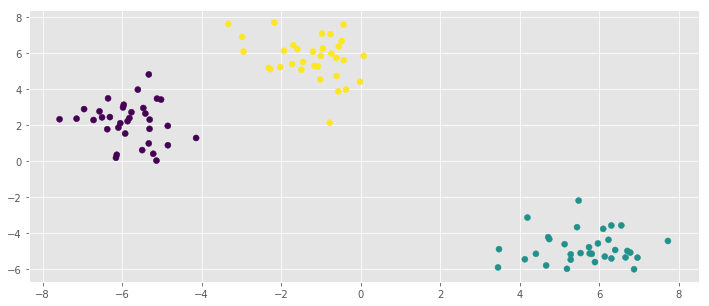

In [19]:
%%time
model = Kmeans_cython_beta1(k=3, max_iter=1000, min_error_rate=0.01, random_state=100)
model.fit(X)
plt.scatter(X[:,0], X[:, 1], c=model.labels)

<h3 align="center">Получилось очень много желтого, очень долгая работа на реальных данных (порядка 20 секунд). Я попытался переписать используя другой подход. Я назову это удачной реализацией на Cython.</h3>

In [21]:
%%cython -a
import numpy as np
cimport numpy as np
import cython
from libc.math cimport sqrt
@cython.boundscheck(False)
@cython.cdivision(True)

cpdef fit_cython(long k, 
                 long max_iter, 
                 np.float64_t eps,
                 np.ndarray[np.float64_t, ndim=2] centroids,
                 np.ndarray[long, ndim=1] labels, 
                 np.ndarray[np.float64_t, ndim=2] X,
                 np.ndarray[long, ndim=1] Npoints_in_cluster,
                 np.ndarray[np.float64_t, ndim=1] suma_centroid):
    
    cdef long shape = X.shape[1]#сколько координат у точки
    cdef np.float64_t nearest=100000.0
    cdef np.float64_t suma_label=0
    cdef long temp_label=0
    cdef long rows = X.shape[0]
        
    #K-means:
    for i in range(0, max_iter):
        #Найдем ближайший центройд для всех точек:
        for p in range(0, rows):
            nearest=100000.0
            for c in range(0, k):
                suma_label=0
                for y in range(0, shape):#y - это все координаты точки
                    suma_label+=(X[p,y]-centroids[c,y])*(X[p,y]-centroids[c,y])
                if (sqrt(suma_label)<nearest):#так как nearest=np.inf, то сюда попадет
                    nearest=sqrt(suma_label)
                    temp_label=c
            labels[p]=temp_label
            Npoints_in_cluster[temp_label]+=1
            
        #Пересчитываю центроиды: 
        for c in range(0, k):
            for y in range(0,shape):
                suma_centroid[y]=0.0
            for p in range(0, rows):
                if labels[p]==c:
                    for y in range(0,shape):
                        suma_centroid[y]+=X[p,y]#suma_centroid=array([[ 0.,  0.]])
            for y in range(0,shape):
                centroids[c,y]=suma_centroid[y]/Npoints_in_cluster[c]
         
        #Обнуляю число точек в кластерах:
        for c in range(0,k):
            Npoints_in_cluster[c]=0
    return labels

In [22]:
from sklearn.base import ClusterMixin,BaseEstimator
class Kmeans_cython_final(BaseEstimator, ClusterMixin):
    def __init__(self, k=3, max_iter=1000, min_error_rate=0.01, random_state=None):
        self.k = k
        self.max_iter = max_iter
        self.min_error_rate=min_error_rate
        self.random_state=random_state
    def fit(self, X):
        c_indexes = np.random.choice(len(X), size=self.k)#init centroids
        self.centroids = np.array([X[i] for i in c_indexes])
        self.labels = np.zeros(X.shape[0],dtype=long)
        self.Npoints_in_cluster = np.zeros(self.k,dtype=long)
        self.suma_centroid=np.empty(X.shape[1],dtype=np.float64)
        self.labels=fit_cython(self.k,
                               self.max_iter, 
                               self.min_error_rate, 
                               self.centroids, self.labels, 
                               X, 
                               self.Npoints_in_cluster,
                               self.suma_centroid)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


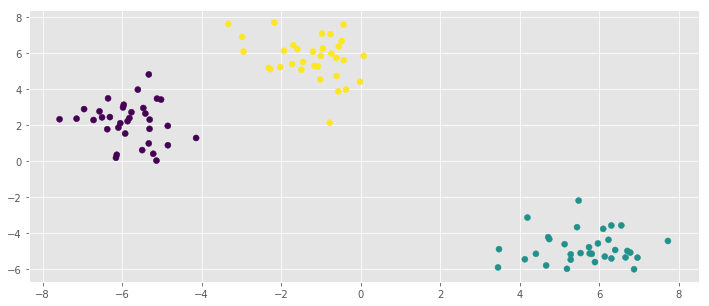

In [23]:
%time
model = Kmeans_cython_final(3, 1000, 0.01)
model.fit(X)
claster_labels=model.labels
plt.scatter(X[:,0], X[:, 1],c=claster_labels)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.96 µs


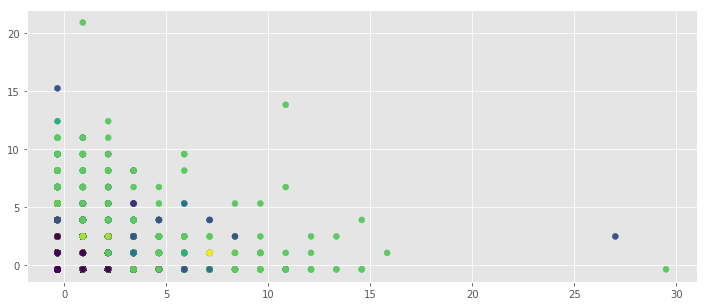

In [24]:
%time
model = Kmeans_cython_final(9, 1000, 0.01)
model.fit(real_data)
claster_labels=model.labels
plt.scatter(real_data[:,0], real_data[:, 1],c=claster_labels)

<h3 align="center">Работает 5 милисекунд на датасете из 30 тыс. данных, а желтого практически не осталось. Я считаю, что на этом можно остановиться.</h3>